# **Clinical Data Science and Machine Learning with Python**
 
## **Day 2**

- **Instructor**: Teresa Krieger, BIH/Charité (teresa.krieger@charite.de)
- **Course date**: November 2021

**Content**:

1.   References
2.   Library imports and data download
3.   Data preparation
4.   Model building
5.   Model training
6.   Model evaluation
7.   Model prediction

---
## **1. References**

In this course, we will use Python 3.6 (default in Colab as of February 2021).
The following documentation and links might be useful to you:

- Deep Learning:
  - https://www.deeplearningbook.org/
- Tensorflow and Keras:
  - https://www.tensorflow.org/tutorials/
  - https://keras.io/guides/
- Source of the pneumonia X-ray dataset:
  - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

You can also take a look at [this](https://www.youtube.com/playlist?list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF) machine learning series on Youtube, where you can learn more about e.g. bias and variance, regand some common machine learning algorithms.

---
## **2. Library imports and data download**

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from google.colab import files

import zipfile
import os
import pickle

%matplotlib inline

In this session, we will be working with chest X-ray images from patients with and without pneumonia. This data is available on Kaggle. Before we can download it, we need to set up a connection to Kaggle in our colab environment:

In [ ]:
!pip install -q kaggle
!wget -O kaggle.json https://www.dropbox.com/s/ewjoj1ge5u130m9/kaggle.json?dl=0
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json



--2021-11-18 16:12:58--  https://www.dropbox.com/s/ewjoj1ge5u130m9/kaggle.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ewjoj1ge5u130m9/kaggle.json [following]
--2021-11-18 16:12:59--  https://www.dropbox.com/s/raw/ewjoj1ge5u130m9/kaggle.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08cb8f47af249f782e0283a44e.dl.dropboxusercontent.com/cd/0/inline/BaObBQPYK3FtbvWfqQgHpGcc9uXW_ZGFikwpmoJw80xQhcs08XFvUCGMVU8w0ddK_g2uodxKUBjp-4w4SL3DRFKQjdxg3pLa9qnjYDt9cnMVPXmcDUiadqCrviKQArMDVaajFib_ZBxlsCImAdtPBFPg/file# [following]
--2021-11-18 16:12:59--  https://uc08cb8f47af249f782e0283a44e.dl.dropboxusercontent.com/cd/0/inline/BaObBQPYK3FtbvWfqQgHpGcc9uXW_ZGFikwpmoJw80xQhcs08XFvUCGMVU8w0ddK_g2uodxKUBjp-4w4SL3DR

Now we can download the data from Kaggle:

In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [01:05<00:00, 52.0MB/s]
100% 2.29G/2.29G [01:05<00:00, 37.5MB/s]


The dataset is organised into 3 folders (train, test, val) and contains subfolders for each image category (PNEUMONIA/NORMAL). There are 5,863 X-Ray images (JPEG) across the two categories. We still need to unzip the compressed data and store the folder names:

In [ ]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', mode='r') as zf:   # Here, mode = 'r' means we are reading the zip file
  zf.extractall()

In [ ]:
img_dir = os.path.join(os.getcwd(), 'chest_xray')
test_img_dir = os.path.join(img_dir, 'test')
train_img_dir = os.path.join(img_dir, 'train')
val_img_dir = os.path.join(img_dir, 'val')

---
## **3. Data preparation**

To prepare the images for processing, we will use the `ImageDataGenerator` function from `Keras`. This function automatically generates batches of image data for training and testing our model. Moreover, it can perform real-time data augmentation, for example by introducing random rotations and vertical or horizontal flips. You can find out more in the documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

For now, we will only apply the `rescale` argument to transform all images to a [0...1] grayscale range instead of [0...255] as is common for RGB images. The generator essentially reads images from the source folders in batches when they are required during training and evaluation. We will therefore set up separate instances for training, validation and testing:





In [ ]:
train_generator = ImageDataGenerator(rescale = 1/255).flow_from_directory(
    'chest_xray/train/',
    target_size = (300,300),
    batch_size = 128,
    class_mode = 'binary'
)

val_generator = ImageDataGenerator(rescale = 1/255).flow_from_directory(
    'chest_xray/val/',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary'
)

test_generator = ImageDataGenerator(rescale = 1/255).flow_from_directory(
    'chest_xray/test/',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


---
## **4. Model building**

The model we are going to build consists of several components:

*   **tf.keras.layers.Conv2D()**: the convolution layer which abstracts images features 
*   **tf.keras.layers.MaxPooling2D()**: a layer to reduce the information in an image while maintaining features
*   **tf.keras.layers.Flatten()**: flattens the result into a one-dimensional array
*   **tf.keras.layers.Dense()**: a densely connected layer

We will build a five-layer convolutional neural network in which each layer consists of a Conv2D() and a MaxPooling2D() step. Then, the output of the final convolutional layer will be flattened and fit to fully connected neurons.



In [ ]:
model = tf.keras.models.Sequential([
  
    # Note the input shape is the size of the image (300 x 300 px) x 3 colours
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
  
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # Flatten output
    tf.keras.layers.Flatten(),

    # Densely connected hidden layer with 512 neurons
    tf.keras.layers.Dense(512, activation='relu'), 

    # One output neuron with a sigmoid activation function - 
    # this will contain a value from 0 ('normal') to 1 ('pneumonia')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

We can inspect the architecture of our model by printing a summary as follows:

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 35, 35, 64)      

Additionally, before the model is fitted for training, it is necessary to configure the specifications as follows:

*   **loss**: with a sigmoid activation function in the final step, we select `binary_crossentropy` as the loss function
*   **optimizer**: `RMSprop` (Root Mean Square Propagation) with a learning rate of 0.001 will be used
*   **metrics**: we will use `accuracy` as our metric to evaluate the prediction accuracy on every epoch

We can now compile the model:

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


---
## **5. Model training**

Now we are ready to train our model. We will train for 10 epochs with 10 steps (= batches of samples) on every epoch, and store our progress in `history`. Note that this might take a few minutes - time for some tea or coffee!

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
10/10 [==============================] - 131s 12s/step - loss: 0.6869 - accuracy: 0.6375 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 123s 12s/step - loss: 0.5423 - accuracy: 0.7692 - val_loss: 1.0136 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 126s 12s/step - loss: 0.5973 - accuracy: 0.7742 - val_loss: 1.2468 - val_accuracy: 0.5625
Epoch 4/10
10/10 [==============================] - 131s 13s/step - loss: 0.3422 - accuracy: 0.8617 - val_loss: 0.6356 - val_accuracy: 0.6875
Epoch 5/10
10/10 [==============================] - 125s 12s/step - loss: 0.2979 - accuracy: 0.8822 - val_loss: 0.7597 - val_accuracy: 0.6250
Epoch 6/10
10/10 [==============================] - 129s 13s/step - loss: 0.2624 - accuracy: 0.8894 - val_loss: 0.3459 - val_accuracy: 0.8125
Epoch 7/10
10/10 [==============================] - 126s 12s/step - loss: 0.2966 - accuracy: 0.8806 - val_loss: 0.3679 - val_accuracy: 0.8750
Epoch 

**Taking too long?** If you've finished your tea or coffee but the above is still not done, you can also interrupt execution of the cell by clicking on `Runtime > Interrupt execution` in the top menu. Now you can just download the result by un-commenting and executing the following code:

In [ ]:
!wget -O history.pickle https://www.dropbox.com/s/p34wvankor1ysiz/history.pickle?dl=0
file_to_read = open('history.pickle', 'rb')
history = pickle.load(file_to_read)
file_to_read.close()

--2021-11-18 17:17:25--  https://www.dropbox.com/s/p34wvankor1ysiz/history.pickle?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/p34wvankor1ysiz/history.pickle [following]
--2021-11-18 17:17:25--  https://www.dropbox.com/s/raw/p34wvankor1ysiz/history.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4deb9a0896d39fe5ada6bd893e.dl.dropboxusercontent.com/cd/0/inline/BaNzC4ODhyd5wkajCALm_MQVsRQExWsEIK2l8_8FKK4usg2i2ypCTbVI0FTwXR73mApyTyHQ5u2QZdwJ9ve_gUtQv3tw2tQTYAmULGyLFsHww36zfpQ24UhQbnN0URAhdRCUCVl6FvMU8hyyduSaJhCw/file# [following]
--2021-11-18 17:17:26--  https://uc4deb9a0896d39fe5ada6bd893e.dl.dropboxusercontent.com/cd/0/inline/BaNzC4ODhyd5wkajCALm_MQVsRQExWsEIK2l8_8FKK4usg2i2ypCTbVI0FTwXR73mApyTyHQ5u2Q

---
## **6. Model evaluation**

To evaluate our model, we can plot the accuracy as a function of training epochs for our training and validation data:

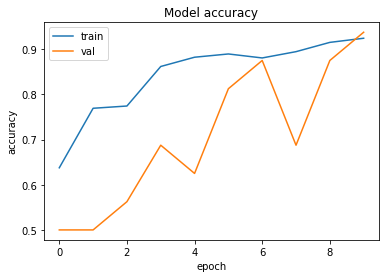

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

---
#### **_Your turn_: Exercises**

**Exercise 1**: Plot the loss instead of the accuracy for training and validation data. Place the legend in the upper right corner of the plot.

---
## **7. Model prediction**

So how does our model perform on unseen data? We can use the `model.evaluate` function to check this.


In [ ]:
result = model.evaluate(test_generator)
print('loss for test data :', result[0])
print('accuracy for test data :', result[1])

5/5 [==============================] - 22s 4s/step - loss: 0.3972 - accuracy: 0.8349
loss for test data : 0.39717409014701843
accuracy for test data : 0.8349359035491943


You will probably receive a prediction accuracy upwards of 80%, which is not bad for such a simple model!

Now our model is ready to make predictions! This can be done with the `model.predict` function. To predict whether a given image corresponds to a patient with or without pneumonia, we first need to download the image file and feed it into the `model.predict` function. For simplicity, we will use a file from the test data set, but we could of course also use our model for any other chest X-ray! 

In [ ]:
Buil!wget -O test_image_1.jpeg https://www.dropbox.com/s/z2dwy069smbrtym/test_image_1.jpeg?dl=0
path = 'test_image_1.jpeg'  # File path to an image from the test data set
img = image.load_img(path, target_size=(300,300))   # Load image
x = image.img_to_array(img)     # Turn image into array
x = np.expand_dims(x, axis=0)   # Add one dimension to match the input size expected by our model

In [ ]:
classes = model.predict(x)
prob_pneumonia = classes[0]

---
#### **_Your turn_: Exercises**

**Exercise 1**: The variable `prob_pneumonia` gives the probability that the image comes from a pneumonia patient. Write a few lines of code to print 'The patient has pneumonia' if this probability is greater than 50%, and 'The patient does not have pneumonia' otherwise.


**Exercise 2**: As (future) medical doctors, you might also want to take a look at the image yourself. You can display it using the `imshow` function of `matplotlib` as shown below. Do you agree with your model?

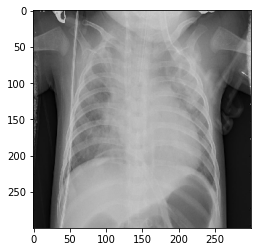

In [ ]:
plt.imshow(img)

**Exercise 3**: If you're still feeling motivated, you can repeat the evaluation for the image file called `test_image_2.jpeg` which you can download from https://www.dropbox.com/s/z471e1sbeac29g7/test_image_2.jpeg?dl=0.

#**Well done!**



